In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

train1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
train2 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
train3 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
train4 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

#load data
maindata = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')


In [4]:
test_df = pd.read_csv(f'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv') 

In [5]:
print(train1.columns)
print(train1.head())  # Display a few rows to inspect the DataFrame structure


Index(['text', 'label', 'source', 'fold'], dtype='object')
                                                text  label           source  \
0  There are alot reasons to keep our the despise...      0  persuade_corpus   
1  Driving smart cars that drive by themself has ...      0  persuade_corpus   
2  Dear Principal,\n\nI believe that students at ...      0  persuade_corpus   
3  Dear Principal,\n\nCommunity service should no...      0  persuade_corpus   
4  My argument for the development of the driverl...      0  persuade_corpus   

   fold  
0     2  
1     4  
2     0  
3     0  
4     3  


In [6]:
# columns of interest
train1 = train1[['text', 'label']]
train1 = train1.set_axis(['text', 'generated'], axis=1)
train2 = train2[['text', 'label']]
train2 = train2.set_axis(['text', 'generated'], axis=1)
train3 = train3[['text', 'label']]
train3 = train3.set_axis(['text', 'generated'], axis=1)
train4 = train4[['text', 'label']]
train4 = train4.set_axis(['text', 'generated'], axis=1)

maindata = maindata[['text', 'generated']]


In [8]:
df = pd.concat([train1, train2, train3, train4, maindata])
missing_values = df.isnull().sum()
print("missing_values_train:\n", missing_values)

missing_values_train:
 text         0
generated    0
dtype: int64


In [13]:
y=df['generated']

In [14]:
from sklearn.model_selection import train_test_split
import tensorflow
import keras
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Text data preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
text_sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(text_sequences,maxlen=2500)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

if tf.test.is_gpu_available():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)
    
input_layer = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 501, output_dim=32)(input_layer)

conv1d_1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv1d_1 = BatchNormalization()(conv1d_1)
conv1d_1 = Dropout(0.2)(conv1d_1)
maxpooling_1 = GlobalMaxPooling1D()(conv1d_1)

flatten_layer = Flatten()(embedding_layer)
hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flatten_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.2)(hidden_layer)

concatenated = Concatenate()([maxpooling_1, hidden_layer])

output_layer = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2500)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 2500, 32)             3081536   ['input_2[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 2496, 128)            20608     ['embedding_1[0][0]']         
                                                                                                  
 flatten_1 (Flatten)         (None, 80000)                0         ['embedding_1[0][0]']         
                                                                                            

In [18]:
# Training the model
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=512)

Epoch 1/10
252/252 [==============================] - 903s 4s/step - loss: 0.1449 - accuracy: 0.9980 - val_loss: 4.2926 - val_accuracy: 0.2936
Epoch 2/10
252/252 [==============================] - 905s 4s/step - loss: 0.1020 - accuracy: 0.9983 - val_loss: 1.6368 - val_accuracy: 0.4601
Epoch 3/10
252/252 [==============================] - 905s 4s/step - loss: 0.0697 - accuracy: 0.9988 - val_loss: 0.0964 - val_accuracy: 0.9829
Epoch 4/10
252/252 [==============================] - 908s 4s/step - loss: 0.0492 - accuracy: 0.9990 - val_loss: 1.2991 - val_accuracy: 0.7500
Epoch 5/10
252/252 [==============================] - 908s 4s/step - loss: 0.0356 - accuracy: 0.9992 - val_loss: 3.7961 - val_accuracy: 0.7243
Epoch 6/10
252/252 [==============================] - 911s 4s/step - loss: 0.0265 - accuracy: 0.9993 - val_loss: 0.9797 - val_accuracy: 0.6397
Epoch 7/10
252/252 [==============================] - 912s 4s/step - loss: 0.0198 - accuracy: 0.9995 - val_loss: 0.0277 - val_accuracy: 0.9964

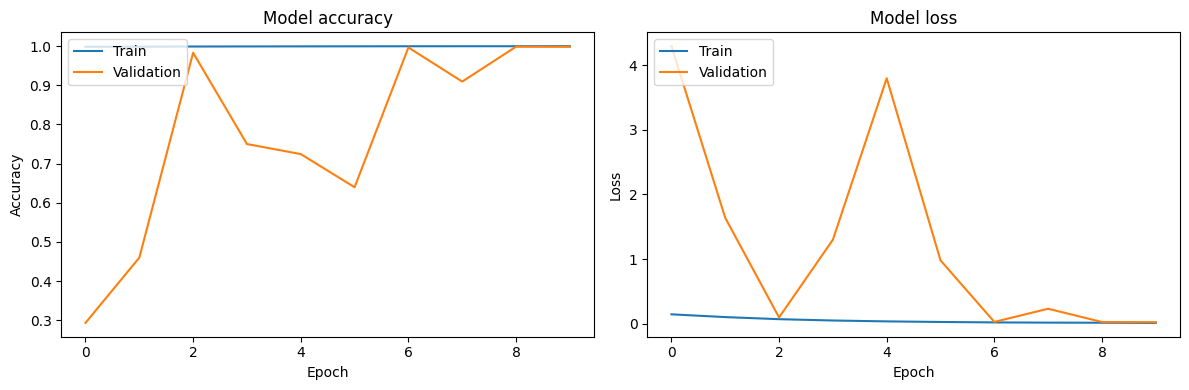

In [19]:
#plotting 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [23]:
text_sequences = tokenizer.texts_to_sequences(test_df['text'])
X_test= pad_sequences(text_sequences, maxlen=2500)

fold_preds = np.zeros(shape=(len(test_df),), dtype='float32')

y = model.predict(X_test)
fold_preds += y.squeeze()

1/1 [==============================] - 0s 119ms/step


In [27]:
sub_df = test_df[["id"]].copy()

In [28]:
# Adding the formatted predictions 
sub_df["generated"] = fold_preds.squeeze()

sub_df.to_csv('submission.csv',index=False)

In [29]:
sub_df.head()


,id,generated
0,0000aaaa,0.985236
1,1111bbbb,0.985040
2,2222cccc,0.985040
